In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import arff
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

from typing import Optional
import joblib

os.environ["OMP_NUM_THREADS"] = '1'


print(
"TensorFlow version:", tf.__version__)
print("Num GPUs Available", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
Num GPUs Available 0


In [8]:
# Load .arff file
#data, meta = arff.loadarff('dataset/Rice_Cammeo_Osmancik.arff')
data, meta = arff.loadarff('dataset/Dry_Bean_Dataset.arff')
df = pd.DataFrame(data)

# Convert binary string to readable format for the 'Class' column
df['Class'] = df['Class'].apply(lambda x: x.decode('utf-8'))

# Basic Data Info
print(df.info())  # check data types and ensure correct loading
print(df['Class'].value_counts())  # check class distribution

# Display the first few rows to understand feature values and ranges
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  float64
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  float64
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [9]:
df.drop(columns=['ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4'], axis=1, inplace=True)

In [10]:
# Mean Imputation
def mean_imputation(df: pd.DataFrame) -> pd.DataFrame:
    """Impute missing values with the mean of each column."""
    imputed_df = df.copy()
    return imputed_df.fillna(imputed_df.mean())

# Median Imputation
def median_imputation(df: pd.DataFrame) -> pd.DataFrame:
    """Impute missing values with the median of each column."""
    imputed_df = df.copy()
    return imputed_df.fillna(imputed_df.median())

# Mode Imputation
def mode_imputation(df: pd.DataFrame) -> pd.DataFrame:
    """Impute missing values with the mode (most frequent value) of each column."""
    imputed_df = df.copy()
    for column in imputed_df.columns:
        mode_val = imputed_df[column].mode()[0]
        imputed_df[column].fillna(mode_val, inplace=True)
    return imputed_df

# K-Nearest Neighbors (KNN) Imputation
def knn_imputation(df: pd.DataFrame, n_neighbors: int = 5) -> pd.DataFrame:
    """Impute missing values using K-Nearest Neighbors."""
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_array = imputer.fit_transform(df)
    return pd.DataFrame(imputed_array, columns=df.columns)

# Constant Imputation
def constant_imputation(df: pd.DataFrame, fill_value: Optional[float] = 0) -> pd.DataFrame:
    """Impute missing values with a constant value (default is 0)."""
    imputed_df = df.copy()
    return imputed_df.fillna(fill_value)

def drop_na(df: pd.DataFrame) -> pd.DataFrame:
    imputed_df = df.copy()
    return imputed_df.dropna()

imputed_df = df.copy()


In [11]:
def plot_bean_counts(df, bean_column='Class'):
    """Plot the count of each bean type."""
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=bean_column, palette='viridis')
    plt.title("Count of Each Bean Type")
    plt.xlabel("Bean Type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

def plot_bean_pairplot(df, bean_column='Class', features=None):
    """
    Plot pairwise relationships for the specified features and color by bean type.
    """
    if features is None:
        features = df.select_dtypes(include='number').columns.tolist()[:5]  # Select first 5 numerical features by default
    sns.pairplot(df, vars=features, hue=bean_column, palette='viridis', plot_kws={'alpha': 0.5})
    plt.suptitle("Pair Plot of Selected Features by Bean Type", y=1.02)
    plt.show()

def plot_bean_pca(df, bean_column='Class'):
    """
    Perform PCA to reduce dimensions to 2D and plot the beans in 2D space.
    """
    features = df.select_dtypes(include='number').columns.tolist()
    X = df[features]
    y = df[bean_column]

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', alpha=0.7)
    plt.title("PCA Plot of Beans (2D)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title=bean_column)
    plt.show()

def plot_bean_boxplot(df, bean_column='Class', feature='feature_name'):
    """
    Plot a box plot for a specific feature across different bean types.
    """
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=bean_column, y=feature, palette='viridis')
    plt.title(f"Distribution of {feature} by Bean Type")
    plt.xlabel("Bean Type")
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.show()

def plot_bean_violinplot(df, bean_column='Class', feature='feature_name'):
    """
    Plot a violin plot for a specific feature across different bean types.
    """
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df, x=bean_column, y=feature, palette='viridis')
    plt.title(f"Violin Plot of {feature} by Bean Type")
    plt.xlabel("Bean Type")
    plt.ylabel(feature)
    plt.xticks(rotation=45)
    plt.show()



In [12]:
def plot_corr_matrix(df: pd.DataFrame) -> pd.DataFrame:
    # Generate correlation matrix
    correlation_matrix = df.drop(columns=['Class']).corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))

    # Draw the heatmap with a color bar
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title("Feature Correlation Matrix")
    plt.show()


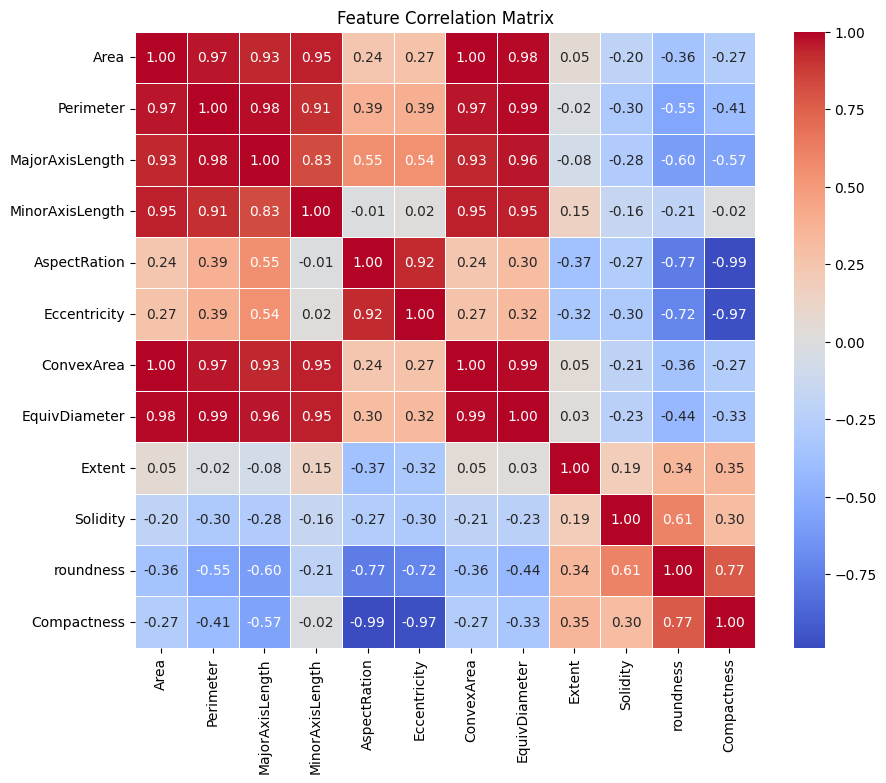

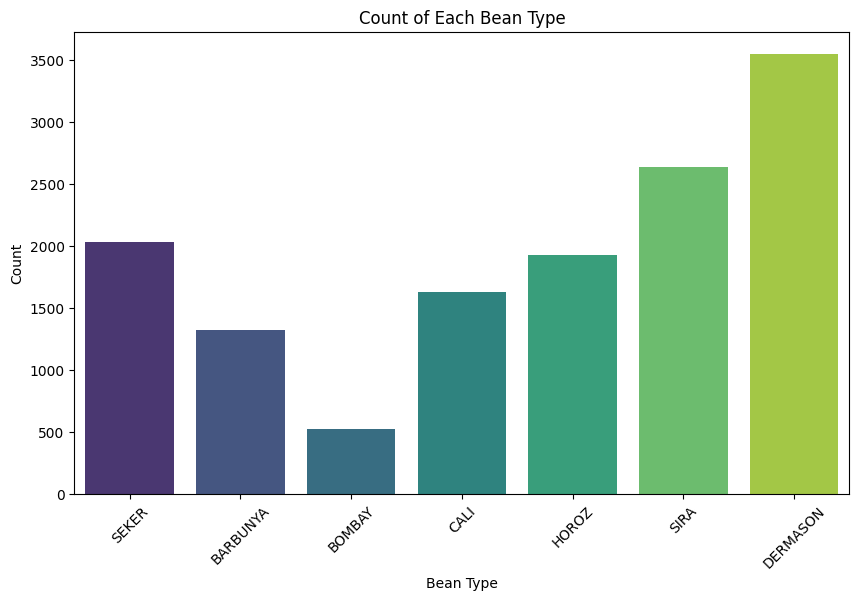

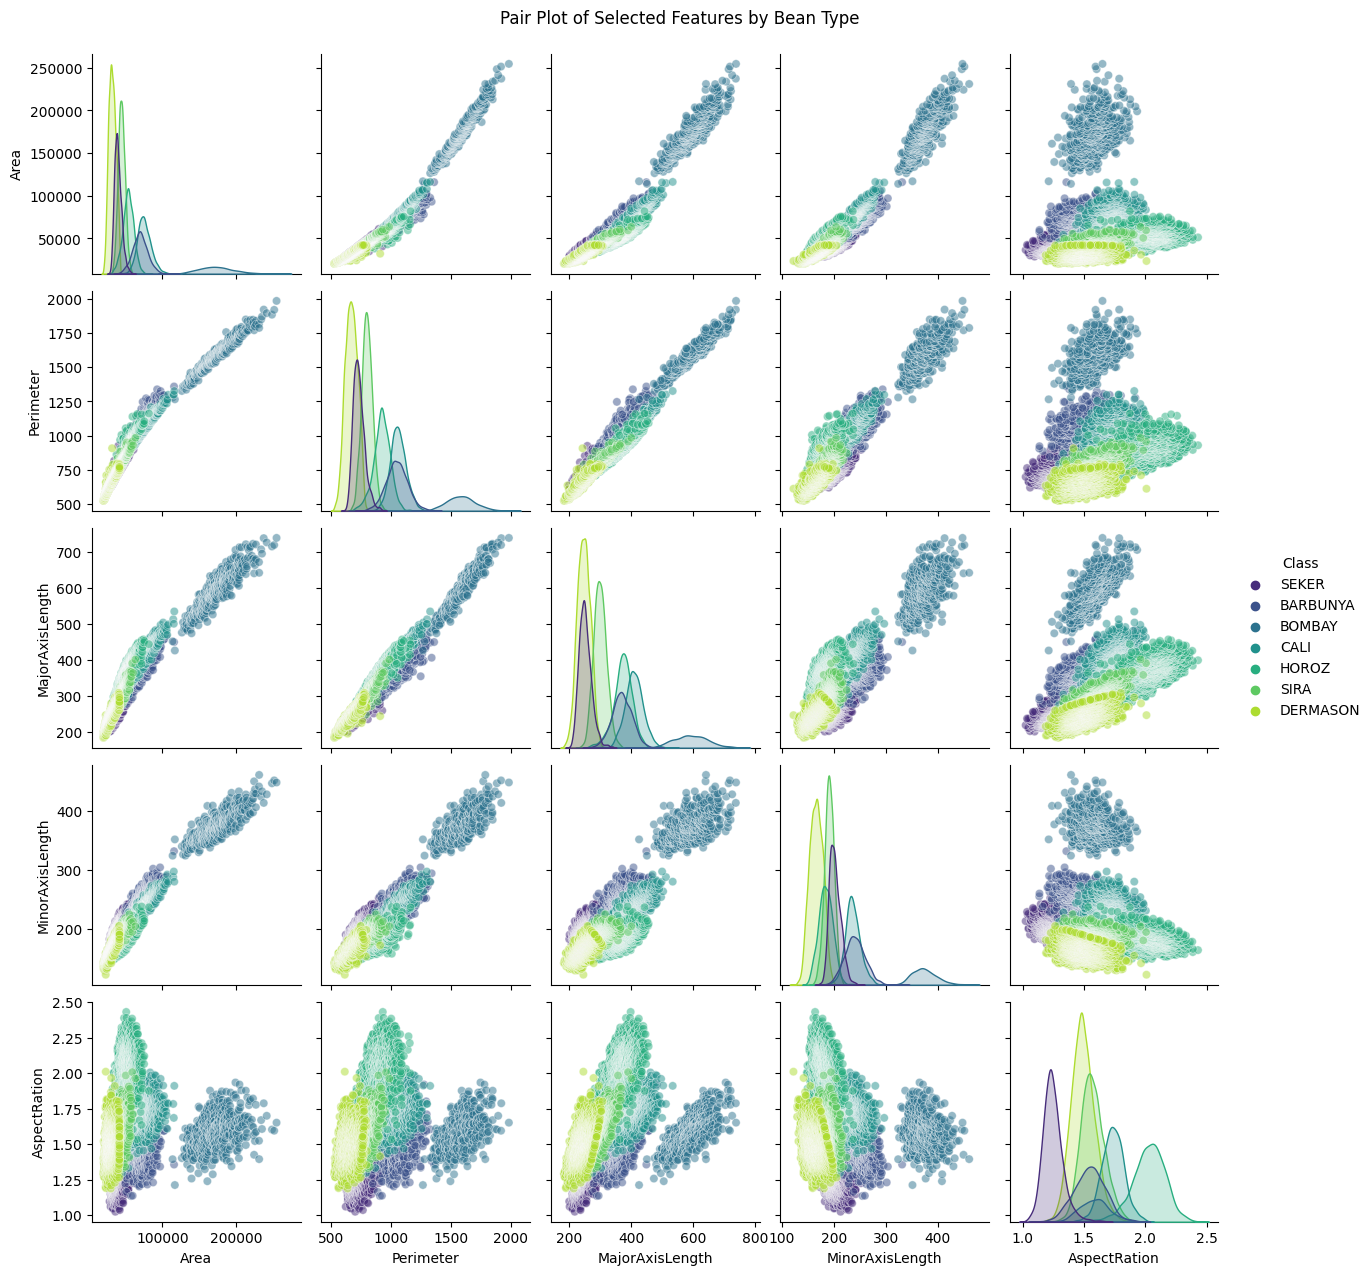

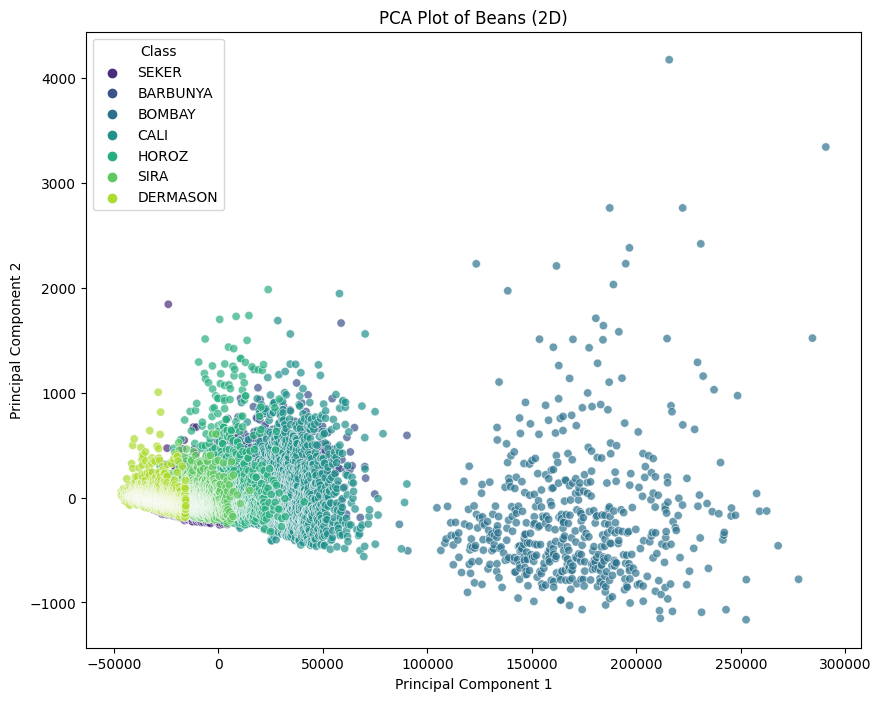

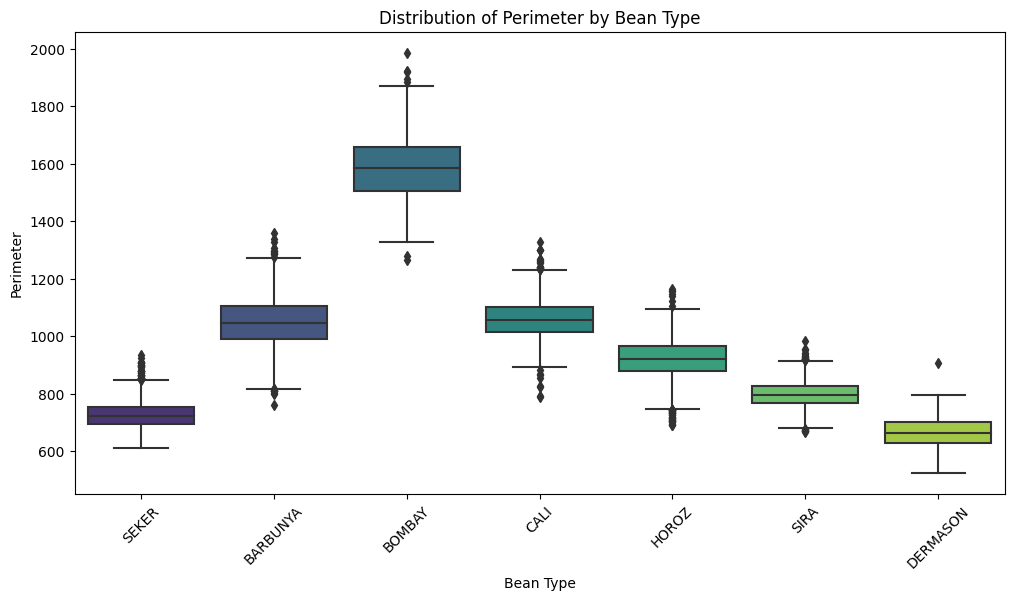

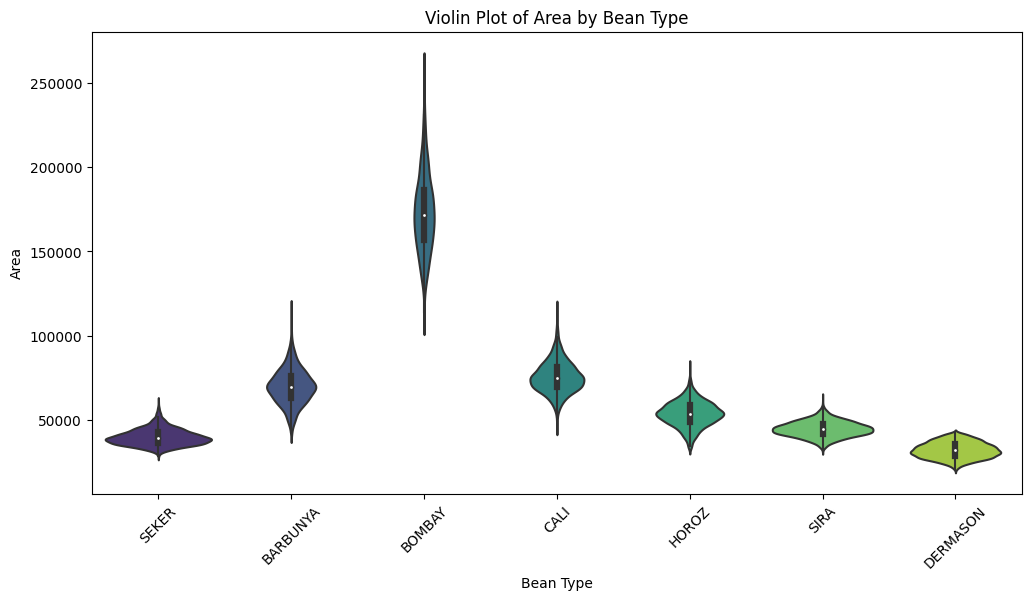

In [16]:
plot_corr_matrix(imputed_df)
plot_bean_counts(imputed_df)
plot_bean_pairplot(imputed_df)
plot_bean_pca(imputed_df)
plot_bean_boxplot(imputed_df, feature='Perimeter')
plot_bean_violinplot(imputed_df, feature='Area')


In [13]:
# Encode the target variable
label_encoder = LabelEncoder()
imputed_df['Class'] = label_encoder.fit_transform(imputed_df['Class'])

# Separate features and target variable
X = imputed_df.drop(columns=['Class'])
y = imputed_df['Class']

# Split into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the feature columns (use fit on train, transform on both train and test)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [23]:
# Build the ANN model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer for multiclass

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Define the ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(7, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to inspect layer structure
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                1088      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 7)                 119       
                                                                 
Total params: 3,815
Trainable params: 3,815
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")


Epoch 1/50
273/273 [==============================] - 1s 3ms/step - loss: 0.5888 - accuracy: 0.8187 - val_loss: 0.2655 - val_accuracy: 0.9141
Epoch 2/50
273/273 [==============================] - 1s 2ms/step - loss: 0.2426 - accuracy: 0.9148 - val_loss: 0.2178 - val_accuracy: 0.9288
Epoch 3/50
273/273 [==============================] - 1s 2ms/step - loss: 0.2175 - accuracy: 0.9203 - val_loss: 0.2136 - val_accuracy: 0.9284
Epoch 4/50
273/273 [==============================] - 1s 2ms/step - loss: 0.2088 - accuracy: 0.9216 - val_loss: 0.1975 - val_accuracy: 0.9343
Epoch 5/50
273/273 [==============================] - 1s 2ms/step - loss: 0.2017 - accuracy: 0.9262 - val_loss: 0.1970 - val_accuracy: 0.9252
Epoch 6/50
273/273 [==============================] - 1s 2ms/step - loss: 0.1992 - accuracy: 0.9273 - val_loss: 0.1913 - val_accuracy: 0.9302
Epoch 7/50
273/273 [==============================] - 1s 2ms/step - loss: 0.1970 - accuracy: 0.9277 - val_loss: 0.1947 - val_accuracy: 0.9302
Epoch 

In [35]:
# Save the model to a file
joblib.dump(model, 'models/ann_model-dry_bean.h5')

INFO:tensorflow:Assets written to: ram://4dd3c1be-e4f4-4b32-bb21-3799da465a56/assets


['models/ann_model-dry_bean.h5']

In [60]:
model = joblib.load('models/ann_model-dry_bean.h5')

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://bc63f9d4-1724-4738-9d3c-cb2031a49162/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [61]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


86/86 [==============================] - 0s 624us/step - loss: 0.1943 - accuracy: 0.9269
Test Accuracy: 0.9269


In [32]:
# Making predictions
predictions = model.predict(X_test)
predicted_classes = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Display predictions
print(predicted_classes)

# Get predicted classes from the prediction probabilities
y_pred = predictions.argmax(axis=1)


86/86 [==============================] - 0s 1ms/step
['DERMASON' 'BOMBAY' 'SIRA' ... 'HOROZ' 'CALI' 'DERMASON']


In [33]:
# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:
               precision    recall  f1-score   support

    BARBUNYA       0.92      0.92      0.92       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.95      0.93      0.94       326
    DERMASON       0.93      0.92      0.92       709
       HOROZ       0.96      0.94      0.95       386
       SEKER       0.94      0.96      0.95       406
        SIRA       0.86      0.89      0.88       527

    accuracy                           0.93      2723
   macro avg       0.94      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723



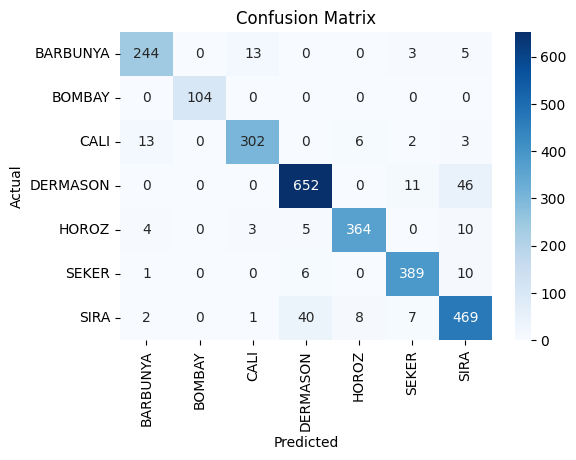

In [34]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()